<a href="https://colab.research.google.com/github/rosalindmpaulson/DLops/blob/main/4_Classification_and_Feature_Extraction_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="color:#6C3483" align="center">Transfer Learning: Fine Tuning and Feature Extraction</h1>

# Convolutional Neural Network (CNN)

In [ ]:
# Pytorch libraries
import torch
import torchvision
import torchvision.transforms as transforms

# For displaying images and numpy operations
import matplotlib.pyplot as plt
import numpy as np

# For CNN Purpose
import torch.nn as nn
import torch.nn.functional as F

# Loss function and optimizer
import torch.optim as optim

###### Initializing Data Loader

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


###### Functions to show an image

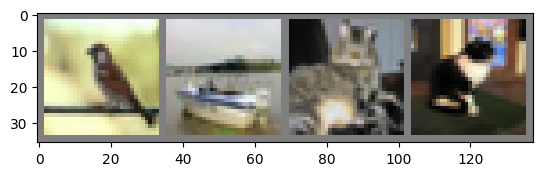

 bird  ship   cat   cat


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# print(labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

##### Define a Convolution Neural Network without Drop Out

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x3 = x.view(-1, 16 * 5 * 5)
        x = self.fc1(x3)
        x = self.relu3(x)
        x2 = self.fc2(x)
        x = self.relu4(x2)
        x = self.fc3(x)
        return (x3, x2, x)

net = Net()

In [ ]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
# Using GPU, if available
use_gpu = torch.cuda.is_available()
print(use_gpu)

if use_gpu:
    net.cuda()

True


##### Define Loss function and optimizer

In [ ]:
# Let’s use a Classification Cross-Entropy loss and SGD with momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

###### Train the network

In [ ]:
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the network and optimize

for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            inputs, labels = inputs, labels

        # zero the parameter gradients
        optimizer.zero_grad()

        feature1, features, outputs = net(inputs)

        # forward + backward + optimize
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.193
[1,  4000] loss: 1.845
[1,  6000] loss: 1.665
[1,  8000] loss: 1.552
[1, 10000] loss: 1.502
[1, 12000] loss: 1.439
Finished Training


In [ ]:
# Saving the model
torch.save(net.state_dict(), 'cifar10Model.pth')

In [ ]:
# Loading the model
net.load_state_dict(torch.load('cifar10Model.pth'))

<All keys matched successfully>

In [ ]:
# Set model to evaluation mode
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Feature Extraction and Classification using CNN

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.cuda(), labels.cuda()

Okay, first step. Let us display an image from the test set to get familiar.

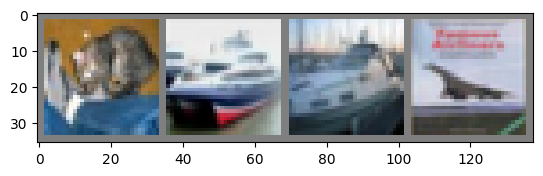

GroundTruth:    cat  ship  ship plane


In [ ]:
# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:

In [ ]:
images = images.to('cuda')
_, _, outputs = net(images)
# outputs = F.softmax(outputs)
#outputs = outputs.cpu()

The outputs are energies for the 10 classes. Higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [ ]:
_, predicted = torch.max(outputs.data, 1)
predicted = predicted.cpu().numpy()
className = list(classes)
print('Predicted: ', ' '.join('%5s' % className[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car  ship


The results seem pretty good with only one epoch.

Let us look at how the network performs on the whole dataset.

In [ ]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()
    _, _, outputs = net(images)
#     outputs = F.softmax(outputs)
    outputs = outputs.cpu()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.cpu()).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 48 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()
    _, _, outputs = net(images)
#     outputs = F.softmax(outputs)
    outputs = outputs.cpu()
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels.cpu()).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 70 %
Accuracy of  bird : 11 %
Accuracy of   cat : 38 %
Accuracy of  deer : 59 %
Accuracy of   dog : 23 %
Accuracy of  frog : 45 %
Accuracy of horse : 75 %
Accuracy of  ship : 55 %
Accuracy of truck : 54 %


# Feature Extraction using CNN

<b>Train Set of CIFAR-10 Dataset</b>

In [ ]:
for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data

    # wrap them in Variable
    if use_gpu:
        inputs, labels = inputs.cuda(), labels.cuda()
    else:
        inputs, labels = inputs, labels

    # extracting features
    _, features, _ = net(inputs)

    if use_gpu:
        features = features.cpu()
        labels = labels.cpu()
    feature = features.data.numpy()
    label = labels.data.numpy()
    label = np.reshape(label,(labels.size(0),1))

    if i==0:
        featureMatrix = np.copy(feature)
        labelVector = np.copy(label)
    else:
        featureMatrix = np.vstack([featureMatrix,feature])
        labelVector = np.vstack([labelVector,label])

print('Finished Feature Extraction for Train Set')

Finished Feature Extraction for Train Set


<b>Test Set of CIFAR-10 Dataset</b>

In [ ]:
for i, data in enumerate(testloader, 0):
    # get the inputs
    inputs, labels = data

    # wrap them in Variable
    if use_gpu:
        inputs, labels = inputs.cuda(), labels.cuda()
    else:
        inputs, labels = inputs, labels

    # extracting features
    _, features, _ = net(inputs)

    if use_gpu:
        features = features.cpu()
        labels = labels.cpu()
    feature = features.data.numpy()
    label = labels.data.numpy()
    label = np.reshape(label,(labels.size(0),1))

    if i==0:
        featureMatrixTest = np.copy(feature)
        labelVectorTest = np.copy(label)
    else:
        featureMatrixTest = np.vstack([featureMatrixTest,feature])
        labelVectorTest = np.vstack([labelVectorTest,label])

print('Finished Feature Extraction for Test Set')

Finished Feature Extraction for Test Set


# Classification Using Random Forest

In [ ]:
# Import Packages for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import joblib

from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Defining Random Forest Claasifier
clf = RandomForestClassifier(n_estimators = 100)
print(clf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [ ]:
# Train the Random Forest using Train Set of CIFAR-10 Dataset
clf.fit(featureMatrix, np.ravel(labelVector))

RandomForestClassifier()

In [ ]:
# Test with Random Forest for Test Set of CIFAR-10 Dataset
labelVectorPredicted = clf.predict(featureMatrixTest)

##### Glimpse of Classifcation Results

In [ ]:
labelVectorTest = np.ravel(labelVectorTest)
className = list(classes)
for i in range(10):
    print(className[labelVectorTest[i]], className[labelVectorPredicted[i]])

cat cat
ship ship
ship ship
plane plane
frog deer
frog frog
car car
frog frog
cat cat
car car


##### Classification Performance over Whole Test Dataset

In [ ]:
correct = (labelVectorPredicted == labelVectorTest).sum()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / labelVectorTest.shape[0]))

Accuracy of the network on the 10000 test images: 53 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
c = (labelVectorPredicted == labelVectorTest).squeeze()
for i in range(labelVectorTest.shape[0]):
    label = labelVectorTest[i]
    class_correct[label] += c[i]
    class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 60 %
Accuracy of   car : 68 %
Accuracy of  bird : 32 %
Accuracy of   cat : 38 %
Accuracy of  deer : 40 %
Accuracy of   dog : 45 %
Accuracy of  frog : 65 %
Accuracy of horse : 60 %
Accuracy of  ship : 69 %
Accuracy of truck : 57 %


#### Determining Feature Importance using Random Forest

In [ ]:
print(clf.feature_importances_)

# Saving the trained model
joblib.dump(clf, 'fc1_forest1.pkl')

# Loading the trained model
ctl = joblib.load('fc1_forest1.pkl')

[0.01559775 0.00940655 0.01101377 0.02152844 0.01099815 0.01398841
 0.01028935 0.00896928 0.01047942 0.01127993 0.01328471 0.01309621
 0.01418785 0.01062396 0.01042977 0.01070761 0.01424282 0.01021541
 0.01027942 0.01328298 0.01410086 0.01687519 0.01078031 0.00931923
 0.01580446 0.01031174 0.00872036 0.01374878 0.01086248 0.01240202
 0.02007365 0.0093358  0.0084746  0.01062525 0.00839839 0.01235773
 0.01704176 0.01163896 0.0124653  0.01512829 0.01573107 0.01028712
 0.00950767 0.00846717 0.00903804 0.00878235 0.01038657 0.00982074
 0.00930637 0.01343946 0.01436297 0.010835   0.01453304 0.01425835
 0.00916367 0.01350598 0.01108508 0.00858063 0.01815816 0.0113689
 0.00826631 0.00928497 0.01217003 0.00902488 0.00920347 0.00929997
 0.00941431 0.01731279 0.01185219 0.01761788 0.0087595  0.01231701
 0.01269778 0.01028802 0.01135019 0.01405617 0.01066103 0.00930249
 0.01041907 0.01158447 0.01549592 0.01216439 0.01114949 0.01332239]


<h2 align="left">References</h2>
<p style="font-size:17px">
a) http://pytorch.org//<br>
b) http://scikit-learn.org/stable/<br>
c) Ho, Tin Kam. "Random decision forests." In Document analysis and recognition, 1995., proceedings of the third international conference on, vol. 1, pp. 278-282. IEEE, 1995.<br>
d) Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." In Advances in neural information processing systems, pp. 1097-1105. 2012.
</p>